# Loop flow example - Refer to Nelleka's work
This is a test case with particles released in a simple looping flow field 
The background flow velocity is given by 

$u=-sin(b*x)*sin(b*y),\ b=2pi/L$
$v=cos(a*x)*sin(a*y), a=pi/H$

The domain is $H \in [0,50], L \in [0,100]$

In [2]:
# Load required libraries
using Pkg
Pkg.instantiate()
Pkg.activate("..")
using Particles
using Plots
using Random

randpool = MersenneTwister(0) #Generate same random numbers every time

nothing

  Activating project at `i:\Master_Thesis\particles.jl`

In [3]:
# Load default settings and adjust

# collected configuration is in Dict d
d = default_userdata() # start with some defaults
# settings for this experiment
n = 30 # number of particles
d["nparticles"] = n
# all variables for one particle are collected in a vector
variables = ["x", "y", "z", "age"]
d["variables"] = variables
# initial position of the particles
m = length(variables)
p = zeros(m, n)
p[1, :] = 50 .+ 1 * randn(randpool, n, 1) # particles are spawned roughly at the center of the graph
p[2, :] = 25 .+ 1 * randn(randpool, n, 1)
d["particles"] = p # initial values
# simulation time
d["dt"] = 0.05     #time-step
d["tstart"] = 0.0 
d["tend"] = 100
# write to netcdf
d["write_maps_times"] = collect(d["tstart"]:d["dt"]:d["tend"])
d["write_maps"] = false #do not write to netcdf
d["write_maps_filename"] = "output_loop.nc"
# write plots to file
d["plot_maps_times"] = collect(d["tstart"]:d["dt"]:d["tend"])
d["plot_maps"] = false # do not make png figures
d["plot_maps_size"]=(600,300)

# keep some output in memory
d["keep_particles"] = true #keep results in memory (bad idea for a large run)
d["keep_particle_times"] = collect(d["tstart"]:20*d["dt"]:d["tend"])

d #show configuration

Dict{String, Any} with 24 entries:
  "plot_maps_prefix"     => "map"
  "write_maps"           => false
  "reftime"              => DateTime("2000-01-01T00:00:00")
  "particles"            => [50.6791 50.8284 … 50.4737 50.3002; 26.423 25.4084 …
  "nparticles"           => 30
  "plot_maps_times"      => [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0…
  "dt"                   => 0.05
  "tend"                 => 100
  "write_maps_dir"       => "."
  "write_maps_filename"  => "output_loop.nc"
  "variables"            => ["x", "y", "z", "age"]
  "keep_particle_times"  => [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …
  "dumval"               => 9999.0
  "write_maps_as_series" => true
  "keep_particles"       => true
  "plot_maps_func"       => plot_maps_xy
  "coordinates"          => "projected"
  "write_maps_times"     => [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0…
  "plot_maps_size"       => (600, 300)
  ⋮                      => ⋮

In [4]:
# Define the flow field
H=50
L=2*H # divergence-free condition
a=pi/H
b=2*pi/L

# sign difference from stream function to velocity

# forcing currents stream (used only for plotting here) , u and v
# flow in x direction (for now has to be called u)
function u(x, y, z, t)
    -sin(b * x) * cos(b * y)
end

# flow in y direction (for now has to be called v)
function v(x, y, z, t)
    cos(a* x) * sin(a * y)
end

nothing

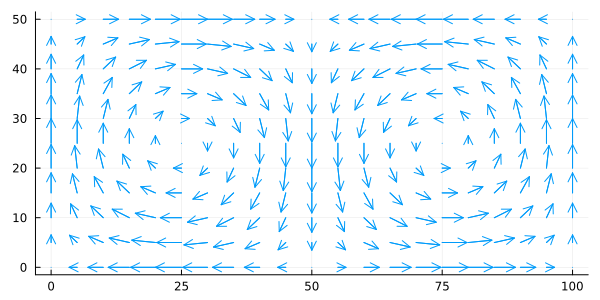

In [5]:
#plot flow field
#grid for plotting
x = 0:5:100
y = 0:5:50
xs=kron(x,ones(length(y)))
ys=kron(ones(length(x)),y)
Plots.default(:size, d["plot_maps_size"])
scale = 5
u_plot = zeros(length(x)*length(y))
v_plot = zeros(length(x)*length(y))
for i = 1:length(x)
    for j = 1:length(y)
        u_plot[(i-1)*length(y)+j] = u(x[i], y[j], 0.0, 0.0)
        v_plot[(i-1)*length(y)+j] = v(x[i], y[j], 0.0, 0.0)
    end
end
quiver(xs,ys,quiver=(scale*u_plot,scale*v_plot))

In [6]:
# Here is the equation that we want to solve for the particles

"""
   !f(ds,s,t,i,d)

Dynamic model, computes time derivative ds of s at current time t
for particle i and possibly using data/functions from d of type userdata.
"""
function f!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
    ∂s.x = u(x, y, z, t)
   # dy/dt=v
    ∂s.y = v(x, y, z, t)
   # dz/dt=0
    ∂s.z = 0.0
   # age=(t-t0)
    ∂s.t = 1.0
end
#d["f"] = f!

f!

In [7]:
###### Velocity function for the particles ######
function f1!(ds, s, t, i, d)
   x, y, z, age = s
   z = 0.0
                                                             # Converts radians to degrees
   up = 0
   vp = 0
   dt = d["dt"]
   uw = u(x, y, z, t)
   vw = v(x, y, z, t)

   # Various models:
   # 0: Use drifer data
   # track_of_drifter!(ds,s,t,d["reftime"],d["dt"],drifter)
   # 1: Only flow velocities
   up = uw
   vp = vw
   # 2: Flow plus a factor times wind
   # up = uw+0.016*ua*0.9
   # vp = vw+0.016*va*0.9
   # 3: Add stokes drift to flow velocity
   # usJ, vsJ = uv_sJ(wh(x,y,z,t),wp(x,y,z,t),wd(x,y,z,t))
   # up = uw+usJ
   # vp = vw+vsJ
   # 4: Combine flow, stokes drift and wind in an equilibrium for the particle velocity
   # usJ, vsJ = uv_sJ(wh(x,y,z,t),wp(x,y,z,t),wd(x,y,z,t))
   # (up,vp) = water_stokes_wind(ua,va, uw,vw,usJ,vsJ)

   # Calculate and add turbulent diffusivity, using Pr=1
   # Estimate the Eddy viscosity and its derivates, using a Smagorinsky model
   # This is only because the horizontal diffusion is not in the flow output files
   
   # original computation for computing the particle velocity
   #(K, Kdx, Kdy) = estimate_viscosity_smag(interp, x, y, t, u, v)
   #if !(uw == vw == ua == va == 0.0)
   #   # https://doi.org/10.1016/j.ocemod.2017.11.008 eq. 27
   #   up += Kdy + randn() * sqrt(2 * K * dt) / dt
   #   vp += Kdx + randn() * sqrt(2 * K * dt) / dt
   #end
   epsx = 1
   epsz = 1e-5
   up += randn()*sqrt(2*epsx*dt)/dt
   vp += randn()*sqrt(2*epsz*dt)/dt

   ds.x = up
   ds.y = vp
   ds.z = 0.0
   ds.t = 1.0


   if d["time_direction"] == :backwards
      up *= -1
      vp *= -1
   end
end
d["f"]=f1!

f1! (generic function with 1 method)

In [8]:
# use streamfunction as background for plotting

function plot_background(d)
    x = 0:5:100
    y = 0:5:50
    xs=kron(x,ones(length(y)))
    ys=kron(ones(length(x)),y)
    Plots.default(:size, d["plot_maps_size"])
    scale = 5
    u_plot = zeros(length(x)*length(y))
    v_plot = zeros(length(x)*length(y))
    for i = 1:length(x)
        for j = 1:length(y)
            u_plot[(i-1)*length(y)+j] = u(x[i], y[j], 0.0, 0.0)
            v_plot[(i-1)*length(y)+j] = v(x[i], y[j], 0.0, 0.0)
        end
    end
    f = quiver(xs,ys,quiver=(scale*u_plot,scale*v_plot))
    return(f)
 end
 d["plot_maps_background"] = plot_background
 

plot_background (generic function with 1 method)

In [ ]:
#run the actual particle model

@time run_simulation(d)

In [10]:
d["plot_maps_func"]

plot_maps_xy (generic function with 1 method)

In [20]:
# screenshot of particles
t_plot=d["keep_particle_times"]
p=d["all_particles"]
for i in 1:length(t_all)
    fig = d["plot_maps_background"](d)
    fname = "vortex\\screenshot_time"*"$(t_plot[i])"*".png"
    d["plot_maps_func"](fig, d, p[i])
    savefig(fig, fname)
end


In [51]:
display(size(p))
display(typeof(p))
display(size(p[1]))
display(size(p[:][:,1]))
display(size(p[:][1,1]))
display(typeof(p[:][1,1]))

display(size(p[1][1,:]))
display(typeof(p[1][1,:]))

(101,)

Vector{Any} (alias for Array{Any, 1})

(4, 30)

(101,)

(4, 30)

Matrix{Float64} (alias for Array{Float64, 2})

(30,)

Vector{Float64} (alias for Array{Float64, 1})

In [29]:
# obtain the location data
display(d["variables"])
display(length(t_plot))
display("Particle number")
display(n)

4-element Vector{String}:
 "x"
 "y"
 "z"
 "age"

101

"Particle number"

30

In [59]:
# plot particles' trajectories
p_x = zeros(length(t_plot), n)
p_y = zeros(length(t_plot), n)
for i in 1:length(t_plot)
    p_x[i, :] = p[i][1,:]
    p_y[i, :] = p[i][2,:]
end

# prepare the data for plotting
# note that the data points at the first and the end are used once
indices = reduce(vcat, [[j for i in 1:2] for j in 1:length(t_plot)])
indices = indices[begin+1:end-1]
fig = d["plot_maps_background"](d)
fname = "vortex\\trajectories.png"

for i in 1:n
    plot!(fig, p_x[indices, i], p_y[indices, i], legend=egend =:outerright, size = (1400, 800))
end

savefig(fig, fname)


"i:\\Master_Thesis\\particles.jl\\example_notebooks\\vortex\\trajectories.png"